# TensorFlow & Keras Advanced: Custom Layers and Deep Architectures

## Part 2: Building Complex Operations from Scratch

---

In Part 1, we learned TensorFlow fundamentals, GradientTape basics, and the high-level Keras API. Now we go deeper!

### What You'll Learn

| Part | Topic | Key Concepts |
|------|-------|-------------|
| **I** | Advanced GradientTape | Nested tapes, Jacobians, custom gradients |
| **II** | Building Ops from Scratch | Convolution, pooling, normalization by hand |
| **III** | Custom Layers (Primitives) | Build layers using only tf.Variable |
| **IV** | Custom Keras Layers | Proper subclassing with `build()` and `call()` |
| **V** | Advanced Architectures | Residual blocks, attention, custom normalizations |
| **VI** | Custom Training Loops | Full control over training with GradientTape |
| **VII** | Practical Demos | Real-world examples with custom components |

---

*"To understand the framework, build it from scratch."*

In [ ]:
# ============================================================================
#                           SETUP & IMPORTS
# ============================================================================

import tensorflow as tf
import keras
from keras import layers, Model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Callable, Union

# Beautiful plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Check versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version:      {keras.__version__}")
print(f"GPU Available:      {len(tf.config.list_physical_devices('GPU')) > 0}")

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("\nReady for Advanced TensorFlow & Keras!")

TensorFlow Version: 2.19.0
Keras Version:      3.10.0
GPU Available:      False

Ready for Advanced TensorFlow & Keras!


---

# Part I: Advanced GradientTape Patterns

## Beyond Basic Gradient Computation

In Part 1, we used GradientTape for simple gradients. Now we'll explore:

- **Nested tapes** for higher-order derivatives
- **Jacobian and Hessian** computation
- **Custom gradients** for non-differentiable operations
- **Gradient clipping** and manipulation

In [ ]:
# ============================================================================
#                    NESTED GRADIENTTAPES: HIGHER-ORDER DERIVATIVES
# ============================================================================

print("="*60)
print("       NESTED TAPES: HIGHER-ORDER DERIVATIVES")
print("="*60)

# Example: Compute first, second, and third derivatives
# f(x) = x^4
# f'(x) = 4x^3
# f''(x) = 12x^2
# f'''(x) = 24x

x = tf.Variable(2.0)

with tf.GradientTape() as tape3:
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape1:
            y = x ** 4
        dy_dx = tape1.gradient(y, x)      # First derivative: 4x^3
    d2y_dx2 = tape2.gradient(dy_dx, x)    # Second derivative: 12x^2
d3y_dx3 = tape3.gradient(d2y_dx2, x)      # Third derivative: 24x

print(f"\nf(x) = x^4, evaluated at x = {x.numpy()}")
print(f"")
print(f"f(x)    = {y.numpy():.1f}         (expected: 16)")
print(f"f'(x)   = {dy_dx.numpy():.1f}         (expected: 32 = 4*8)")
print(f"f''(x)  = {d2y_dx2.numpy():.1f}         (expected: 48 = 12*4)")
print(f"f'''(x) = {d3y_dx3.numpy():.1f}         (expected: 48 = 24*2)")

       NESTED TAPES: HIGHER-ORDER DERIVATIVES

f(x) = x^4, evaluated at x = 2.0

f(x)    = 16.0         (expected: 16)
f'(x)   = 32.0         (expected: 32 = 4*8)
f''(x)  = 48.0         (expected: 48 = 12*4)
f'''(x) = 48.0         (expected: 48 = 24*2)


In [ ]:
# ============================================================================
#                    JACOBIAN COMPUTATION
# ============================================================================

print("="*60)
print("              JACOBIAN COMPUTATION")
print("="*60)

# The Jacobian is the matrix of all first-order partial derivatives
# For f: R^n -> R^m, the Jacobian J is m x n where J[i,j] = df_i/dx_j

x = tf.Variable([1.0, 2.0, 3.0])

with tf.GradientTape() as tape:
    # Vector function: f(x) = [x1^2, x1*x2, sin(x3)]
    y = tf.stack([
        x[0] ** 2,
        x[0] * x[1],
        tf.sin(x[2])
    ])

# Compute full Jacobian
jacobian = tape.jacobian(y, x)

print(f"\nx = {x.numpy()}")
print(f"y = f(x) = [x1^2, x1*x2, sin(x3)] = {y.numpy()}")
print(f"\nJacobian (3x3):")
print(f"{jacobian.numpy()}")

print(f"\nExpected Jacobian:")
print(f"  [2*x1,   0,      0   ]   = [2,   0,     0     ]")
print(f"  [x2,     x1,     0   ]   = [2,   1,     0     ]")
print(f"  [0,      0,  cos(x3) ]   = [0,   0,  {np.cos(3):.4f}]")

              JACOBIAN COMPUTATION

x = [1. 2. 3.]
y = f(x) = [x1^2, x1*x2, sin(x3)] = [1.      2.      0.14112]

Jacobian (3x3):
[[ 2.         0.         0.       ]
 [ 2.         1.         0.       ]
 [ 0.         0.        -0.9899925]]

Expected Jacobian:
  [2*x1,   0,      0   ]   = [2,   0,     0     ]
  [x2,     x1,     0   ]   = [2,   1,     0     ]
  [0,      0,  cos(x3) ]   = [0,   0,  -0.9900]


In [ ]:
# ============================================================================
#                    HESSIAN COMPUTATION
# ============================================================================

print("="*60)
print("              HESSIAN COMPUTATION")
print("="*60)

# The Hessian is the matrix of second-order partial derivatives
# H[i,j] = d^2f / (dx_i dx_j)

x = tf.Variable([1.0, 2.0])

with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape1:
        # Scalar function: f(x, y) = x^2*y + y^3
        f = x[0]**2 * x[1] + x[1]**3
    grad = tape1.gradient(f, x)  # [2xy, x^2 + 3y^2]
hessian = tape2.jacobian(grad, x)

print(f"\nf(x, y) = x^2*y + y^3, at (x, y) = ({x[0].numpy()}, {x[1].numpy()})")
print(f"f = {f.numpy()}")
print(f"\nGradient: {grad.numpy()}")
print(f"  Expected: [2xy, x^2 + 3y^2] = [4, 13]")
print(f"\nHessian:")
print(f"{hessian.numpy()}")
print(f"  Expected:")
print(f"  [2y,  2x ]   = [4, 2]")
print(f"  [2x,  6y ]   = [2, 12]")

              HESSIAN COMPUTATION

f(x, y) = x^2*y + y^3, at (x, y) = (1.0, 2.0)
f = 10.0

Gradient: [ 4. 13.]
  Expected: [2xy, x^2 + 3y^2] = [4, 13]

Hessian:
[[ 4.  2.]
 [ 2. 12.]]
  Expected:
  [2y,  2x ]   = [4, 2]
  [2x,  6y ]   = [2, 12]


In [ ]:
# ============================================================================
#                    CUSTOM GRADIENTS
# ============================================================================

print("="*60)
print("              CUSTOM GRADIENTS")
print("="*60)

# Sometimes you need to define custom gradients:
# - For non-differentiable operations (like argmax)
# - For numerical stability
# - For custom backward passes (like straight-through estimators)

@tf.custom_gradient
def clip_gradient_norm(x, clip_value=1.0):
    """
    Forward: identity function
    Backward: clip gradient norm
    """
    def grad(dy):
        # Clip the incoming gradient
        norm = tf.norm(dy)
        clipped = tf.cond(
            norm > clip_value,
            lambda: dy * clip_value / norm,
            lambda: dy
        )
        return clipped  # Only return gradient for 'x'
    return x, grad

# Test custom gradient
x = tf.Variable([3.0, 4.0])  # Gradient will have norm 5 (3-4-5 triangle)

with tf.GradientTape() as tape:
    y = clip_gradient_norm(x, clip_value=1.0)
    loss = tf.reduce_sum(y)  # Gradient would be [1, 1] but we pass [3, 4]

# Manually set upstream gradient to [3, 4]
grad = tape.gradient(loss, x)
print(f"\nInput: {x.numpy()}")
print(f"Gradient (clipped to norm 1.0): {grad.numpy()}")
print(f"Gradient norm: {tf.norm(grad).numpy():.4f}")

              CUSTOM GRADIENTS

Input: [3. 4.]
Gradient (clipped to norm 1.0): [0.70710677 0.70710677]
Gradient norm: 1.0000


In [ ]:
# ============================================================================
#                    STRAIGHT-THROUGH ESTIMATOR
# ============================================================================

print("="*60)
print("         STRAIGHT-THROUGH ESTIMATOR")
print("="*60)

# The straight-through estimator is used for:
# - Binary/discrete operations that are non-differentiable
# - Quantization in neural networks

@tf.custom_gradient
def straight_through_round(x):
    """
    Forward: round to nearest integer
    Backward: pass gradient through unchanged (identity)
    """
    def grad(dy):
        return dy  # Straight-through: gradient = identity
    return tf.round(x), grad

@tf.custom_gradient
def straight_through_sign(x):
    """
    Forward: sign function (-1, 0, or 1)
    Backward: gradient of hard tanh (1 if |x| <= 1, else 0)
    """
    def grad(dy):
        # Gradient is 1 where |x| <= 1, 0 elsewhere
        return dy * tf.cast(tf.abs(x) <= 1, dy.dtype)
    return tf.sign(x), grad

# Test
x = tf.Variable([0.3, 0.7, 1.2, 2.5])

with tf.GradientTape() as tape:
    y = straight_through_round(x)
    loss = tf.reduce_sum(y ** 2)

grad = tape.gradient(loss, x)

print(f"\nInput:   {x.numpy()}")
print(f"Rounded: {y.numpy()}")
print(f"Gradient (straight-through): {grad.numpy()}")
print(f"\n Note: Round is non-differentiable, but we can still train!")

         STRAIGHT-THROUGH ESTIMATOR

Input:   [0.3 0.7 1.2 2.5]
Rounded: [0. 1. 1. 2.]
Gradient (straight-through): [0. 2. 2. 4.]

 Note: Round is non-differentiable, but we can still train!


In [ ]:
# ============================================================================
#                    GRADIENT ACCUMULATION
# ============================================================================

print("="*60)
print("            GRADIENT ACCUMULATION")
print("="*60)

# Gradient accumulation is useful when:
# - Batch size is too large for GPU memory
# - You want effective larger batch sizes

def train_with_accumulation(model, data, labels, batch_size, accumulation_steps, optimizer):
    """
    Train with gradient accumulation.
    Effective batch size = batch_size * accumulation_steps
    """
    n_samples = len(data)
    accumulated_gradients = [tf.zeros_like(v) for v in model.trainable_variables]

    for step in range(accumulation_steps):
        # Get mini-batch
        start = (step * batch_size) % n_samples
        end = start + batch_size
        x_batch = data[start:end]
        y_batch = labels[start:end]

        with tf.GradientTape() as tape:
            predictions = model(x_batch, training=True)
            loss = tf.reduce_mean(keras.losses.mse(y_batch, predictions))

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)

        # Accumulate (average over steps)
        accumulated_gradients = [
            acc + grad / accumulation_steps
            for acc, grad in zip(accumulated_gradients, gradients)
        ]

    # Apply accumulated gradients
    optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
    return loss

print("\nGradient Accumulation Pattern:")
print("  1. Compute gradients for mini-batch")
print("  2. Accumulate (sum or average) over N steps")
print("  3. Apply accumulated gradients once")
print("  4. Effective batch = mini_batch * N")

            GRADIENT ACCUMULATION

Gradient Accumulation Pattern:
  1. Compute gradients for mini-batch
  2. Accumulate (sum or average) over N steps
  3. Apply accumulated gradients once
  4. Effective batch = mini_batch * N


---

# Part II: Building Operations from Scratch

## Understanding Neural Network Primitives

Before using Keras layers, let's understand what they do by building them ourselves.

In [ ]:
# ============================================================================
#                    CONVOLUTION FROM SCRATCH
# ============================================================================

print("="*60)
print("           CONVOLUTION FROM SCRATCH")
print("="*60)

def conv2d_naive(input_tensor, kernel, stride=1, padding='VALID'):
    """
    Naive 2D convolution implementation.

    Parameters
    ----------
    input_tensor : tensor (batch, height, width, in_channels)
    kernel : tensor (kernel_h, kernel_w, in_channels, out_channels)
    stride : int
    padding : 'VALID' or 'SAME'
    """
    batch_size = tf.shape(input_tensor)[0]
    in_h, in_w = input_tensor.shape[1], input_tensor.shape[2]
    k_h, k_w = kernel.shape[0], kernel.shape[1]
    out_channels = kernel.shape[3]

    if padding == 'SAME':
        pad_h = k_h // 2
        pad_w = k_w // 2
        input_tensor = tf.pad(input_tensor,
                              [[0, 0], [pad_h, pad_h], [pad_w, pad_w], [0, 0]])
        in_h += 2 * pad_h
        in_w += 2 * pad_w

    out_h = (in_h - k_h) // stride + 1
    out_w = (in_w - k_w) // stride + 1

    output = tf.TensorArray(dtype=tf.float32, size=out_h * out_w)
    idx = 0

    for i in range(out_h):
        for j in range(out_w):
            # Extract patch
            h_start = i * stride
            w_start = j * stride
            patch = input_tensor[:, h_start:h_start+k_h, w_start:w_start+k_w, :]

            # Convolve: sum over (h, w, in_channels), keep out_channels
            # patch: (batch, k_h, k_w, in_c)
            # kernel: (k_h, k_w, in_c, out_c)
            conv = tf.einsum('bhwi,hwio->bo', patch, kernel)
            output = output.write(idx, conv)
            idx += 1

    output = output.stack()  # (out_h*out_w, batch, out_c)
    output = tf.transpose(output, [1, 0, 2])  # (batch, out_h*out_w, out_c)
    output = tf.reshape(output, [batch_size, out_h, out_w, out_channels])

    return output

# Test our implementation
x = tf.random.normal((1, 5, 5, 1))  # 1 image, 5x5, 1 channel
kernel = tf.random.normal((3, 3, 1, 2))  # 3x3 kernel, 1->2 channels

our_output = conv2d_naive(x, kernel, stride=1, padding='VALID')
tf_output = tf.nn.conv2d(x, kernel, strides=1, padding='VALID')

print(f"\nInput shape:  {x.shape}")
print(f"Kernel shape: {kernel.shape}")
print(f"Output shape: {our_output.shape}")
print(f"Matches tf.nn.conv2d: {tf.reduce_all(tf.abs(our_output - tf_output) < 1e-5).numpy()}")

           CONVOLUTION FROM SCRATCH

Input shape:  (1, 5, 5, 1)
Kernel shape: (3, 3, 1, 2)
Output shape: (1, 3, 3, 2)
Matches tf.nn.conv2d: True


In [ ]:
# ============================================================================
#                    MAX POOLING FROM SCRATCH
# ============================================================================

print("="*60)
print("           MAX POOLING FROM SCRATCH")
print("="*60)

def max_pool2d_naive(input_tensor, pool_size=2, stride=2):
    """
    Naive max pooling implementation.

    For each pool_size x pool_size window, take the maximum.
    """
    batch_size = tf.shape(input_tensor)[0]
    in_h, in_w, channels = input_tensor.shape[1:]

    out_h = (in_h - pool_size) // stride + 1
    out_w = (in_w - pool_size) // stride + 1

    outputs = []

    for i in range(out_h):
        row = []
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            # Extract window
            window = input_tensor[:, h_start:h_start+pool_size,
                                  w_start:w_start+pool_size, :]
            # Max over spatial dimensions
            pooled = tf.reduce_max(window, axis=[1, 2])
            row.append(pooled)
        outputs.append(tf.stack(row, axis=1))

    return tf.stack(outputs, axis=1)

# Test
x = tf.constant([[[[1., 2.], [3., 4.], [5., 6.], [7., 8.]],
                  [[9., 10.], [11., 12.], [13., 14.], [15., 16.]],
                  [[17., 18.], [19., 20.], [21., 22.], [23., 24.]],
                  [[25., 26.], [27., 28.], [29., 30.], [31., 32.]]]])

print(f"\nInput shape: {x.shape}")
print(f"Input (channel 0):")
print(x[0, :, :, 0].numpy())

our_pool = max_pool2d_naive(x, pool_size=2, stride=2)
tf_pool = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')

print(f"\nOutput shape: {our_pool.shape}")
print(f"Output (channel 0):")
print(our_pool[0, :, :, 0].numpy())
print(f"\nMatches tf.nn.max_pool2d: {tf.reduce_all(our_pool == tf_pool).numpy()}")

           MAX POOLING FROM SCRATCH

Input shape: (1, 4, 4, 2)
Input (channel 0):
[[ 1.  3.  5.  7.]
 [ 9. 11. 13. 15.]
 [17. 19. 21. 23.]
 [25. 27. 29. 31.]]

Output shape: (1, 2, 2, 2)
Output (channel 0):
[[11. 15.]
 [27. 31.]]

Matches tf.nn.max_pool2d: True


In [ ]:
# ============================================================================
#                    BATCH NORMALIZATION FROM SCRATCH
# ============================================================================

print("="*60)
print("        BATCH NORMALIZATION FROM SCRATCH")
print("="*60)

class BatchNormFromScratch:
    """
    Batch Normalization implemented from scratch.

    During training:
        x_norm = (x - batch_mean) / sqrt(batch_var + epsilon)
        y = gamma * x_norm + beta

    During inference:
        Use running mean and variance instead of batch statistics.
    """

    def __init__(self, num_features, epsilon=1e-5, momentum=0.1):
        self.epsilon = epsilon
        self.momentum = momentum

        # Learnable parameters
        self.gamma = tf.Variable(tf.ones(num_features), name='gamma')
        self.beta = tf.Variable(tf.zeros(num_features), name='beta')

        # Running statistics (not trainable)
        self.running_mean = tf.Variable(tf.zeros(num_features), trainable=False)
        self.running_var = tf.Variable(tf.ones(num_features), trainable=False)

    def __call__(self, x, training=True):
        if training:
            # Compute batch statistics
            batch_mean = tf.reduce_mean(x, axis=0)
            batch_var = tf.math.reduce_variance(x, axis=0)

            # Update running statistics
            self.running_mean.assign(
                (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            )
            self.running_var.assign(
                (1 - self.momentum) * self.running_var + self.momentum * batch_var
            )

            mean, var = batch_mean, batch_var
        else:
            mean, var = self.running_mean, self.running_var

        # Normalize
        x_norm = (x - mean) / tf.sqrt(var + self.epsilon)

        # Scale and shift
        return self.gamma * x_norm + self.beta

    @property
    def trainable_variables(self):
        return [self.gamma, self.beta]

# Test
bn = BatchNormFromScratch(num_features=4)
x = tf.random.normal((8, 4))  # Batch of 8, 4 features

y_train = bn(x, training=True)
y_eval = bn(x, training=False)

print(f"\nInput shape: {x.shape}")
print(f"Input mean per feature: {tf.reduce_mean(x, axis=0).numpy()}")
print(f"Input std per feature:  {tf.math.reduce_std(x, axis=0).numpy()}")
print(f"\nOutput (training) mean: {tf.reduce_mean(y_train, axis=0).numpy()}")
print(f"Output (training) std:  {tf.math.reduce_std(y_train, axis=0).numpy()}")
print(f"\n After BatchNorm, each feature has ~0 mean and ~1 std!")

        BATCH NORMALIZATION FROM SCRATCH

Input shape: (8, 4)
Input mean per feature: [ 0.32574826 -0.22160122  0.37827352  0.3575499 ]
Input std per feature:  [0.8102391  0.74234474 1.061351   1.0821929 ]

Output (training) mean: [-2.9802322e-08  4.6566129e-08  7.4505806e-09 -2.2351742e-08]
Output (training) std:  [0.9999923 0.9999908 0.9999955 0.9999958]

 After BatchNorm, each feature has ~0 mean and ~1 std!


In [ ]:
# ============================================================================
#                    LAYER NORMALIZATION FROM SCRATCH
# ============================================================================

print("="*60)
print("        LAYER NORMALIZATION FROM SCRATCH")
print("="*60)

class LayerNormFromScratch:
    """
    Layer Normalization: Normalize across features (not batch).

    Used in Transformers because:
    - Works with any batch size (including 1)
    - No running statistics needed
    - Each sample normalized independently
    """

    def __init__(self, normalized_shape, epsilon=1e-5):
        self.epsilon = epsilon
        self.normalized_shape = normalized_shape

        # Learnable parameters
        self.gamma = tf.Variable(tf.ones(normalized_shape), name='gamma')
        self.beta = tf.Variable(tf.zeros(normalized_shape), name='beta')

    def __call__(self, x):
        # Compute statistics across last dimensions
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)

        # Normalize
        x_norm = (x - mean) / tf.sqrt(var + self.epsilon)

        # Scale and shift
        return self.gamma * x_norm + self.beta

    @property
    def trainable_variables(self):
        return [self.gamma, self.beta]

# Test
ln = LayerNormFromScratch(normalized_shape=4)
x = tf.random.normal((2, 3, 4))  # (batch, seq, features)

y = ln(x)

print(f"\nInput shape: {x.shape}")
print(f"\nFor sample [0, 0, :]:")
print(f"  Input:  {x[0, 0, :].numpy()}")
print(f"  Output: {y[0, 0, :].numpy()}")
print(f"  Output mean: {tf.reduce_mean(y[0, 0, :]).numpy():.6f}")
print(f"  Output std:  {tf.math.reduce_std(y[0, 0, :]).numpy():.4f}")

print(f"\n Key difference:")
print(f"  BatchNorm: normalize across batch (for each feature)")
print(f"  LayerNorm: normalize across features (for each sample)")

        LAYER NORMALIZATION FROM SCRATCH

Input shape: (2, 3, 4)

For sample [0, 0, :]:
  Input:  [ 0.65648675 -0.4130517   0.33997506 -1.0056272 ]
  Output: [ 1.1744822  -0.47392502  0.6866642  -1.3872216 ]
  Output mean: -0.000000
  Output std:  1.0000

 Key difference:
  BatchNorm: normalize across batch (for each feature)
  LayerNorm: normalize across features (for each sample)


In [ ]:
# ============================================================================
#                    DROPOUT FROM SCRATCH
# ============================================================================

print("="*60)
print("            DROPOUT FROM SCRATCH")
print("="*60)

def dropout_from_scratch(x, rate=0.5, training=True):
    """
    Dropout: Randomly zero out neurons during training.

    Key insight: Scale by 1/(1-rate) during training so that
    expected value remains the same during inference.
    """
    if not training or rate == 0:
        return x

    # Create random mask
    keep_prob = 1 - rate
    mask = tf.cast(
        tf.random.uniform(tf.shape(x)) < keep_prob,
        dtype=x.dtype
    )

    # Apply mask and scale
    return (x * mask) / keep_prob

# Test
x = tf.ones((2, 10))

print(f"Input: all ones, shape {x.shape}")
print(f"")

# Multiple dropout samples
for i in range(3):
    dropped = dropout_from_scratch(x, rate=0.5, training=True)
    print(f"Dropout sample {i+1}: {dropped[0].numpy()}")

print(f"\nDuring inference (training=False):")
print(f"  Output: {dropout_from_scratch(x, rate=0.5, training=False)[0].numpy()}")

# Verify expected value is preserved
samples = tf.stack([dropout_from_scratch(x, rate=0.5) for _ in range(1000)])
print(f"\nAverage over 1000 samples: {tf.reduce_mean(samples).numpy():.4f} (should be ~1.0)")

            DROPOUT FROM SCRATCH
Input: all ones, shape (2, 10)

Dropout sample 1: [0. 2. 2. 0. 0. 2. 0. 2. 2. 0.]
Dropout sample 2: [0. 2. 2. 2. 0. 0. 2. 2. 2. 0.]
Dropout sample 3: [2. 0. 2. 2. 2. 0. 0. 2. 2. 2.]

During inference (training=False):
  Output: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Average over 1000 samples: 1.0045 (should be ~1.0)


---

# Part III: Custom Layers Using Primitives

## Building Layers with tf.Variable Only

Before using Keras's layer system, let's build fully functional layers using only basic TensorFlow operations. This shows exactly what happens under the hood.

In [ ]:
# ============================================================================
#                    DENSE LAYER FROM PRIMITIVES
# ============================================================================

print("="*60)
print("          DENSE LAYER FROM PRIMITIVES")
print("="*60)

class DenseLayerPrimitive:
    """
    Fully connected layer using only tf.Variable.

    Mathematically: y = activation(x @ W + b)
    """

    def __init__(self, in_features, out_features, activation=None, use_bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias

        # Select activation
        self.activation = {
            None: lambda x: x,
            'relu': tf.nn.relu,
            'sigmoid': tf.nn.sigmoid,
            'tanh': tf.nn.tanh,
            'softmax': lambda x: tf.nn.softmax(x, axis=-1)
        }.get(activation, activation)  # Allow passing functions directly

        # He initialization for weights
        stddev = np.sqrt(2.0 / in_features)
        self.W = tf.Variable(
            tf.random.normal((in_features, out_features), stddev=stddev),
            trainable=True,
            name='kernel'
        )

        if use_bias:
            self.b = tf.Variable(
                tf.zeros(out_features),
                trainable=True,
                name='bias'
            )

    def __call__(self, x):
        """Forward pass: y = activation(x @ W + b)"""
        out = x @ self.W
        if self.use_bias:
            out = out + self.b
        return self.activation(out)

    @property
    def trainable_variables(self):
        if self.use_bias:
            return [self.W, self.b]
        return [self.W]

    def __repr__(self):
        return f"DenseLayerPrimitive({self.in_features}, {self.out_features})"

# Test
dense = DenseLayerPrimitive(4, 3, activation='relu')
x = tf.random.normal((2, 4))
y = dense(x)

print(f"\nDenseLayerPrimitive(4, 3, activation='relu')")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Weight shape: {dense.W.shape}")
print(f"Bias shape:   {dense.b.shape}")
print(f"\nOutput:\n{y.numpy()}")

          DENSE LAYER FROM PRIMITIVES

DenseLayerPrimitive(4, 3, activation='relu')
Input shape:  (2, 4)
Output shape: (2, 3)
Weight shape: (4, 3)
Bias shape:   (3,)

Output:
[[0.         0.         0.46504724]
 [0.         0.         0.8249154 ]]


In [ ]:
# ============================================================================
#                    CONV2D LAYER FROM PRIMITIVES
# ============================================================================

print("="*60)
print("          CONV2D LAYER FROM PRIMITIVES")
print("="*60)

class Conv2DLayerPrimitive:
    """
    2D Convolutional layer using only tf.Variable and tf.nn.conv2d.
    """

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding='SAME', activation=None, use_bias=True):
        self.stride = stride
        self.padding = padding
        self.use_bias = use_bias

        # Handle kernel_size as int or tuple
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # Select activation
        self.activation = {
            None: lambda x: x,
            'relu': tf.nn.relu,
            'sigmoid': tf.nn.sigmoid,
            'tanh': tf.nn.tanh,
        }.get(activation, activation)

        # He initialization
        fan_in = kernel_size[0] * kernel_size[1] * in_channels
        stddev = np.sqrt(2.0 / fan_in)

        # Kernel shape: (height, width, in_channels, out_channels)
        self.kernel = tf.Variable(
            tf.random.normal((kernel_size[0], kernel_size[1], in_channels, out_channels),
                           stddev=stddev),
            trainable=True,
            name='kernel'
        )

        if use_bias:
            self.bias = tf.Variable(
                tf.zeros(out_channels),
                trainable=True,
                name='bias'
            )

    def __call__(self, x):
        """Forward pass using tf.nn.conv2d"""
        out = tf.nn.conv2d(x, self.kernel, strides=self.stride, padding=self.padding)
        if self.use_bias:
            out = out + self.bias
        return self.activation(out)

    @property
    def trainable_variables(self):
        if self.use_bias:
            return [self.kernel, self.bias]
        return [self.kernel]

# Test
conv = Conv2DLayerPrimitive(3, 16, kernel_size=3, activation='relu')
x = tf.random.normal((1, 28, 28, 3))  # 1 image, 28x28, 3 channels
y = conv(x)

print(f"\nConv2DLayerPrimitive(3, 16, kernel_size=3)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Kernel shape: {conv.kernel.shape}")
print(f"Parameters:   {np.prod(conv.kernel.shape) + conv.bias.shape[0]}")

          CONV2D LAYER FROM PRIMITIVES

Conv2DLayerPrimitive(3, 16, kernel_size=3)
Input shape:  (1, 28, 28, 3)
Output shape: (1, 28, 28, 16)
Kernel shape: (3, 3, 3, 16)
Parameters:   448


In [ ]:
# ============================================================================
#                    COMPLETE CNN FROM PRIMITIVES
# ============================================================================

print("="*60)
print("          COMPLETE CNN FROM PRIMITIVES")
print("="*60)

class CNNFromPrimitives:
    """
    A complete CNN built using only primitive layers.

    Architecture:
        Conv(3x3) -> ReLU -> MaxPool -> Conv(3x3) -> ReLU -> MaxPool -> Flatten -> Dense -> Dense
    """

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        in_channels = input_shape[-1]

        # Convolutional layers
        self.conv1 = Conv2DLayerPrimitive(in_channels, 32, kernel_size=3, activation='relu')
        self.conv2 = Conv2DLayerPrimitive(32, 64, kernel_size=3, activation='relu')

        # Calculate flattened size after convolutions and pooling
        # With SAME padding and 2x2 pooling twice: H/4, W/4
        h, w = input_shape[0] // 4, input_shape[1] // 4
        flat_size = h * w * 64

        # Dense layers
        self.fc1 = DenseLayerPrimitive(flat_size, 128, activation='relu')
        self.fc2 = DenseLayerPrimitive(128, num_classes, activation='softmax')

        self.layers = [self.conv1, self.conv2, self.fc1, self.fc2]

    def __call__(self, x, training=True):
        # Conv block 1
        x = self.conv1(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')

        # Conv block 2
        x = self.conv2(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')

        # Flatten
        x = tf.reshape(x, (tf.shape(x)[0], -1))

        # Dense layers
        x = self.fc1(x)
        if training:
            x = dropout_from_scratch(x, rate=0.5, training=True)
        x = self.fc2(x)

        return x

    @property
    def trainable_variables(self):
        variables = []
        for layer in self.layers:
            variables.extend(layer.trainable_variables)
        return variables

    def summary(self):
        print("\n" + "="*50)
        print("        CNN FROM PRIMITIVES - SUMMARY")
        print("="*50)
        total = 0
        for i, layer in enumerate(self.layers):
            params = sum(np.prod(v.shape) for v in layer.trainable_variables)
            total += params
            print(f"Layer {i+1}: {layer.__class__.__name__:20} | Params: {params:,}")
        print("-"*50)
        print(f"Total trainable parameters: {total:,}")

# Create and test
cnn = CNNFromPrimitives(input_shape=(28, 28, 1), num_classes=10)
cnn.summary()

# Test forward pass
x = tf.random.normal((4, 28, 28, 1))
y = cnn(x)
print(f"\nInput shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output sum per sample: {tf.reduce_sum(y, axis=1).numpy()}  (should be ~1.0)")

          COMPLETE CNN FROM PRIMITIVES

        CNN FROM PRIMITIVES - SUMMARY
Layer 1: Conv2DLayerPrimitive | Params: 320
Layer 2: Conv2DLayerPrimitive | Params: 18,496
Layer 3: DenseLayerPrimitive  | Params: 401,536
Layer 4: DenseLayerPrimitive  | Params: 1,290
--------------------------------------------------
Total trainable parameters: 421,642

Input shape:  (4, 28, 28, 1)
Output shape: (4, 10)
Output sum per sample: [0.9999999 1.        1.        0.9999999]  (should be ~1.0)


---

# Part IV: Custom Keras Layers

## The Proper Way to Build Custom Layers

Keras provides a clean API for custom layers with:
- **`build()`**: Create weights when input shape is known
- **`call()`**: Define the forward pass
- **`get_config()`**: Enable serialization

This gives you all the benefits of primitives PLUS:
- Automatic weight tracking
- Serialization/deserialization
- Integration with `model.fit()`
- Proper shape inference

In [ ]:
# ============================================================================
#                    CUSTOM KERAS LAYER: BASICS
# ============================================================================

print("="*60)
print("          CUSTOM KERAS LAYER: BASICS")
print("="*60)

class CustomDenseLayer(keras.layers.Layer):
    """
    Custom Dense layer demonstrating the Keras layer API.

    Key methods:
    - __init__: Store configuration (no weights yet!)
    - build: Create weights when input shape is known
    - call: Forward pass
    - get_config: For serialization
    """

    def __init__(self, units, activation=None, use_bias=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias

    def build(self, input_shape):
        """
        Create weights. Called automatically the first time the layer is used.

        self.add_weight() creates a tf.Variable and registers it properly.
        """
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',  # Xavier initialization
            trainable=True
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )

        # Mark as built
        super().build(input_shape)

    def call(self, inputs):
        """Forward pass."""
        output = tf.matmul(inputs, self.kernel)
        if self.use_bias:
            output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_config(self):
        """Enable serialization."""
        config = super().get_config()
        config.update({
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias
        })
        return config

# Test custom layer
custom_dense = CustomDenseLayer(32, activation='relu')
x = tf.random.normal((4, 16))
y = custom_dense(x)  # This triggers build()

print(f"\nCustomDenseLayer(32, activation='relu')")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Kernel shape: {custom_dense.kernel.shape}")
print(f"Trainable variables: {len(custom_dense.trainable_variables)}")
print(f"\nConfig: {custom_dense.get_config()}")

          CUSTOM KERAS LAYER: BASICS

CustomDenseLayer(32, activation='relu')
Input shape:  (4, 16)
Output shape: (4, 32)
Kernel shape: (16, 32)
Trainable variables: 2

Config: {'name': 'custom_dense_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 32, 'activation': 'relu', 'use_bias': True}


In [ ]:
# ============================================================================
#                    CUSTOM LAYER: SELF-ATTENTION
# ============================================================================

print("="*60)
print("         CUSTOM LAYER: SELF-ATTENTION")
print("="*60)

class SelfAttentionLayer(keras.layers.Layer):
    """
    Self-Attention layer (simplified version of Transformer attention).

    Attention(Q, K, V) = softmax(Q @ K^T / sqrt(d_k)) @ V

    In self-attention, Q, K, V all come from the same input.
    """

    def __init__(self, embed_dim, num_heads=1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

    def build(self, input_shape):
        # Linear projections for Q, K, V
        self.W_q = self.add_weight(
            name='W_q',
            shape=(input_shape[-1], self.embed_dim),
            initializer='glorot_uniform'
        )
        self.W_k = self.add_weight(
            name='W_k',
            shape=(input_shape[-1], self.embed_dim),
            initializer='glorot_uniform'
        )
        self.W_v = self.add_weight(
            name='W_v',
            shape=(input_shape[-1], self.embed_dim),
            initializer='glorot_uniform'
        )
        self.W_o = self.add_weight(
            name='W_o',
            shape=(self.embed_dim, self.embed_dim),
            initializer='glorot_uniform'
        )
        super().build(input_shape)

    def call(self, inputs, mask=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        # Linear projections
        Q = inputs @ self.W_q  # (batch, seq, embed)
        K = inputs @ self.W_k
        V = inputs @ self.W_v

        # Reshape for multi-head attention
        Q = tf.reshape(Q, (batch_size, seq_len, self.num_heads, self.head_dim))
        K = tf.reshape(K, (batch_size, seq_len, self.num_heads, self.head_dim))
        V = tf.reshape(V, (batch_size, seq_len, self.num_heads, self.head_dim))

        # Transpose to (batch, heads, seq, head_dim)
        Q = tf.transpose(Q, [0, 2, 1, 3])
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])

        # Attention scores: Q @ K^T / sqrt(d_k)
        scale = tf.sqrt(tf.cast(self.head_dim, tf.float32))
        scores = tf.matmul(Q, K, transpose_b=True) / scale  # (batch, heads, seq, seq)

        # Apply mask if provided
        if mask is not None:
            scores += (1 - mask) * -1e9

        # Softmax
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Apply attention to values
        context = tf.matmul(attention_weights, V)  # (batch, heads, seq, head_dim)

        # Reshape back
        context = tf.transpose(context, [0, 2, 1, 3])  # (batch, seq, heads, head_dim)
        context = tf.reshape(context, (batch_size, seq_len, self.embed_dim))

        # Output projection
        output = context @ self.W_o

        return output, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads
        })
        return config

# Test
attention = SelfAttentionLayer(embed_dim=64, num_heads=4)
x = tf.random.normal((2, 10, 64))  # (batch, seq_len, embed_dim)
output, weights = attention(x)

print(f"\nSelfAttentionLayer(embed_dim=64, num_heads=4)")
print(f"Input shape:            {x.shape}")
print(f"Output shape:           {output.shape}")
print(f"Attention weights shape: {weights.shape}")
print(f"Trainable parameters:   {sum(np.prod(v.shape) for v in attention.trainable_variables):,}")

         CUSTOM LAYER: SELF-ATTENTION

SelfAttentionLayer(embed_dim=64, num_heads=4)
Input shape:            (2, 10, 64)
Output shape:           (2, 10, 64)
Attention weights shape: (2, 4, 10, 10)
Trainable parameters:   16,384


In [ ]:
# ============================================================================
#                    CUSTOM LAYER: SPECTRAL NORMALIZATION
# ============================================================================

print("="*60)
print("       CUSTOM LAYER: SPECTRAL NORMALIZATION")
print("="*60)

class SpectralNormalization(keras.layers.Wrapper):
    """
    Spectral Normalization wrapper for layers.

    Constrains the spectral norm (largest singular value) of the weight matrix.
    Used in GANs to stabilize training.

    W_normalized = W / sigma(W)
    where sigma(W) is the largest singular value.
    """

    def __init__(self, layer, power_iterations=1, epsilon=1e-12, **kwargs):
        super().__init__(layer, **kwargs)
        self.power_iterations = power_iterations
        self.epsilon = epsilon

    def build(self, input_shape):
        self.layer.build(input_shape)

        # Get the weight matrix
        self.w = self.layer.kernel
        w_shape = self.w.shape.as_list()

        # Flatten weight to 2D for SVD
        self.w_flat_shape = (np.prod(w_shape[:-1]), w_shape[-1])

        # Initialize u vector (for power iteration)
        self.u = self.add_weight(
            name='u',
            shape=(1, w_shape[-1]),
            initializer='random_normal',
            trainable=False
        )

        super().build(input_shape)

    def call(self, inputs, training=True):
        # Power iteration to estimate largest singular value
        w_flat = tf.reshape(self.w, self.w_flat_shape)

        u = self.u
        for _ in range(self.power_iterations):
            # v = W^T u / ||W^T u||
            v = tf.matmul(u, tf.transpose(w_flat))
            v = v / (tf.norm(v, ord='euclidean') + self.epsilon)

            # u = W v / ||W v||
            u = tf.matmul(v, w_flat)
            u = u / (tf.norm(u, ord='euclidean') + self.epsilon)

        if training:
            self.u.assign(u)

        # Spectral norm: sigma = u^T W v
        # Corrected calculation for row vectors u (1, out_features) and v (1, in_features)
        # The formula should be v W u^T
        sigma = tf.matmul(tf.matmul(v, w_flat), tf.transpose(u))

        # Normalize weight
        w_normalized = self.w / sigma[0, 0]

        # Manually perform the forward pass of the wrapped layer using w_normalized.
        # This assumes the wrapped layer is a Dense layer based on the test case.
        output = tf.matmul(inputs, w_normalized)

        # If the wrapped layer has a bias and uses it, add it.
        if hasattr(self.layer, 'bias') and self.layer.use_bias:
            output = output + self.layer.bias

        # If the wrapped layer has an activation function, apply it.
        if hasattr(self.layer, 'activation') and self.layer.activation is not None:
            output = self.layer.activation(output)

        return output

# Test
base_layer = layers.Dense(64)
spectral_dense = SpectralNormalization(base_layer)
x = tf.random.normal((4, 32))
y = spectral_dense(x)

print(f"\nSpectralNormalization(Dense(64))")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"\n Use case: Stabilize GAN discriminator training")

       CUSTOM LAYER: SPECTRAL NORMALIZATION

SpectralNormalization(Dense(64))
Input shape:  (4, 32)
Output shape: (4, 64)

 Use case: Stabilize GAN discriminator training


---

# Part V: Advanced Architectures

## Building Modern Deep Learning Components

Now let's build advanced architectural components used in state-of-the-art models:

- **Residual Blocks** (ResNet)
- **Squeeze-and-Excitation** (SENet)
- **Transformer Encoder Block**
- **Custom Normalization Layers**

In [ ]:
# ============================================================================
#                    RESIDUAL BLOCK (ResNet Style)
# ============================================================================

print("="*60)
print("           RESIDUAL BLOCK (ResNet)")
print("="*60)

class ResidualBlock(keras.layers.Layer):
    """
    Residual Block: y = F(x) + x

    The key insight: learning residual F(x) = y - x is easier than learning y directly.
    This enables training very deep networks (100+ layers).
    """

    def __init__(self, filters, kernel_size=3, stride=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.stride = stride

        # Main path
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=stride,
                                    padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters, kernel_size, strides=1,
                                    padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

        # Skip connection (identity or projection)
        self.skip_conv = None
        self.skip_bn = None

    def build(self, input_shape):
        # Need projection if dimensions change
        if input_shape[-1] != self.filters or self.stride != 1:
            self.skip_conv = layers.Conv2D(self.filters, 1, strides=self.stride,
                                           padding='same', use_bias=False)
            self.skip_bn = layers.BatchNormalization()
        super().build(input_shape)

    def call(self, inputs, training=False):
        # Main path
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Skip connection
        if self.skip_conv is not None:
            skip = self.skip_conv(inputs)
            skip = self.skip_bn(skip, training=training)
        else:
            skip = inputs

        # Add and activate
        return tf.nn.relu(x + skip)

# Test
res_block = ResidualBlock(64, stride=1)
x = tf.random.normal((2, 32, 32, 64))
y = res_block(x)

print(f"\nResidualBlock(64)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")

# With downsampling
res_block_down = ResidualBlock(128, stride=2)
y_down = res_block_down(x)
print(f"\nResidualBlock(128, stride=2)")
print(f"Output shape: {y_down.shape}  (spatial dims halved, channels doubled)")

           RESIDUAL BLOCK (ResNet)

ResidualBlock(64)
Input shape:  (2, 32, 32, 64)
Output shape: (2, 32, 32, 64)

ResidualBlock(128, stride=2)
Output shape: (2, 16, 16, 128)  (spatial dims halved, channels doubled)


In [ ]:
# ============================================================================
#                    SQUEEZE-AND-EXCITATION BLOCK
# ============================================================================

print("="*60)
print("         SQUEEZE-AND-EXCITATION BLOCK")
print("="*60)

class SqueezeExcitationBlock(keras.layers.Layer):
    """
    Squeeze-and-Excitation (SE) Block.

    Learns channel-wise attention weights:
    1. Squeeze: Global average pooling (H,W,C) -> (1,1,C)
    2. Excitation: FC -> ReLU -> FC -> Sigmoid
    3. Scale: Multiply input by attention weights
    """

    def __init__(self, reduction_ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        reduced_channels = max(channels // self.reduction_ratio, 1)

        self.fc1 = layers.Dense(reduced_channels, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')

        super().build(input_shape)

    def call(self, inputs):
        # Squeeze: Global Average Pooling
        squeezed = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)  # (B, 1, 1, C)

        # Excitation
        x = tf.reshape(squeezed, (tf.shape(inputs)[0], -1))  # (B, C)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.reshape(x, (tf.shape(inputs)[0], 1, 1, -1))  # (B, 1, 1, C)

        # Scale
        return inputs * x

# Test
se_block = SqueezeExcitationBlock(reduction_ratio=16)
x = tf.random.normal((2, 28, 28, 64))
y = se_block(x)

print(f"\nSqueezeExcitationBlock(reduction_ratio=16)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"\n SE learns which channels are important for the task")

         SQUEEZE-AND-EXCITATION BLOCK

SqueezeExcitationBlock(reduction_ratio=16)
Input shape:  (2, 28, 28, 64)
Output shape: (2, 28, 28, 64)

 SE learns which channels are important for the task


In [ ]:
# ============================================================================
#                    TRANSFORMER ENCODER BLOCK
# ============================================================================

print("="*60)
print("          TRANSFORMER ENCODER BLOCK")
print("="*60)

class TransformerEncoderBlock(keras.layers.Layer):
    """
    Transformer Encoder Block.

    Architecture:
        x -> LayerNorm -> MultiHeadAttention -> + (residual) ->
             LayerNorm -> FeedForward -> + (residual) -> output
    """

    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim

        # Multi-head attention
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads
        )

        # Feed-forward network
        self.ffn = Sequential([
            layers.Dense(ff_dim, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate)
        ])

        # Layer normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # Dropout
        self.dropout1 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        # Pre-norm architecture (more stable)
        # Attention block
        x = self.layernorm1(inputs)
        attn_output = self.attention(x, x, attention_mask=mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        x = inputs + attn_output  # Residual connection

        # Feed-forward block
        ffn_input = self.layernorm2(x)
        ffn_output = self.ffn(ffn_input, training=training)

        return x + ffn_output  # Residual connection

# Test
transformer_block = TransformerEncoderBlock(
    embed_dim=64,
    num_heads=4,
    ff_dim=256,
    dropout_rate=0.1
)

x = tf.random.normal((2, 20, 64))  # (batch, seq_len, embed_dim)
y = transformer_block(x)

print(f"\nTransformerEncoderBlock(embed_dim=64, num_heads=4, ff_dim=256)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Parameters:   {sum(np.prod(v.shape) for v in transformer_block.trainable_variables):,}")

          TRANSFORMER ENCODER BLOCK

TransformerEncoderBlock(embed_dim=64, num_heads=4, ff_dim=256)
Input shape:  (2, 20, 64)
Output shape: (2, 20, 64)
Parameters:   49,984


---

# Part VI: Custom Training Loops

## Full Control with GradientTape

While `model.fit()` is convenient, custom training loops give you:

- **Complete control** over the training process
- **Custom metrics** and logging
- **Complex training schemes** (GANs, reinforcement learning)
- **Gradient manipulation** (clipping, accumulation)
- **Multi-GPU/TPU** strategies

In [ ]:
# ============================================================================
#                    BASIC CUSTOM TRAINING LOOP
# ============================================================================

print("="*60)
print("          BASIC CUSTOM TRAINING LOOP")
print("="*60)

def custom_training_loop(model, train_data, val_data, epochs, learning_rate=0.001):
    """
    Complete custom training loop with GradientTape.
    """
    optimizer = keras.optimizers.Adam(learning_rate)
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    # Metrics
    train_loss = keras.metrics.Mean()
    train_acc = keras.metrics.SparseCategoricalAccuracy()
    val_loss = keras.metrics.Mean()
    val_acc = keras.metrics.SparseCategoricalAccuracy()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Reset metrics
        train_loss.reset_state()
        train_acc.reset_state()

        # Training loop
        for x_batch, y_batch in train_data:
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)

            # Backward pass
            gradients = tape.gradient(loss, model.trainable_variables)

            # Update weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update metrics
            train_loss.update_state(loss)
            train_acc.update_state(y_batch, predictions)

        # Validation loop
        val_loss.reset_state()
        val_acc.reset_state()

        for x_batch, y_batch in val_data:
            predictions = model(x_batch, training=False)
            loss = loss_fn(y_batch, predictions)
            val_loss.update_state(loss)
            val_acc.update_state(y_batch, predictions)

        # Record history
        history['train_loss'].append(train_loss.result().numpy())
        history['train_acc'].append(train_acc.result().numpy())
        history['val_loss'].append(val_loss.result().numpy())
        history['val_acc'].append(val_acc.result().numpy())

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss.result():.4f} | "
              f"Train Acc: {train_acc.result():.4f} | "
              f"Val Loss: {val_loss.result():.4f} | "
              f"Val Acc: {val_acc.result():.4f}")

    return history

print("\nCustom training loop template created!")
print("Key components:")
print("  1. GradientTape for computing gradients")
print("  2. optimizer.apply_gradients() for weight updates")
print("  3. Metrics for tracking performance")

          BASIC CUSTOM TRAINING LOOP

Custom training loop template created!
Key components:
  1. GradientTape for computing gradients
  2. optimizer.apply_gradients() for weight updates
  3. Metrics for tracking performance


In [ ]:
# ============================================================================
#                    TRAINING WITH GRADIENT CLIPPING
# ============================================================================

print("="*60)
print("        TRAINING WITH GRADIENT CLIPPING")
print("="*60)

@tf.function
def train_step_with_clipping(model, x, y, optimizer, loss_fn, clip_norm=1.0):
    """
    Single training step with gradient clipping.

    Gradient clipping prevents exploding gradients in deep networks.
    """
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Clip gradients by global norm
    gradients, global_norm = tf.clip_by_global_norm(gradients, clip_norm)

    # Apply clipped gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, global_norm

print("Gradient Clipping Options:")
print("  - tf.clip_by_value(g, -clip, clip)  : Clip element-wise")
print("  - tf.clip_by_norm(g, clip)          : Clip each tensor by L2 norm")
print("  - tf.clip_by_global_norm(grads, clip): Clip all gradients together")
print("\nGlobal norm is most common - maintains gradient direction!")

        TRAINING WITH GRADIENT CLIPPING
Gradient Clipping Options:
  - tf.clip_by_value(g, -clip, clip)  : Clip element-wise
  - tf.clip_by_norm(g, clip)          : Clip each tensor by L2 norm
  - tf.clip_by_global_norm(grads, clip): Clip all gradients together

Global norm is most common - maintains gradient direction!


In [ ]:
# ============================================================================
#                    CUSTOM MODEL WITH train_step()
# ============================================================================

print("="*60)
print("        CUSTOM MODEL WITH train_step()")
print("="*60)

class CustomTrainableModel(keras.Model):
    """
    Model with custom training logic built-in.

    Override train_step() to customize what happens in model.fit().
    This is the best of both worlds:
    - Custom training logic
    - Still use model.fit() with callbacks, validation, etc.
    """

    def __init__(self, units_list, num_classes, **kwargs):
        super().__init__(**kwargs)

        self.dense_layers = []
        for units in units_list:
            self.dense_layers.append(layers.Dense(units, activation='relu'))
            self.dense_layers.append(layers.Dropout(0.2))

        self.output_layer = layers.Dense(num_classes, activation='softmax')

        # Custom metrics
        self.loss_tracker = keras.metrics.Mean(name='loss')
        self.acc_tracker = keras.metrics.SparseCategoricalAccuracy(name='accuracy')

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x, training=training)
        return self.output_layer(x)

    def train_step(self, data):
        """
        Custom training step.
        Called by model.fit() for each batch.
        """
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = keras.losses.sparse_categorical_crossentropy(y, y_pred)
            loss = tf.reduce_mean(loss)

        # Compute and apply gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(y, y_pred)

        return {
            'loss': self.loss_tracker.result(),
            'accuracy': self.acc_tracker.result()
        }

    def test_step(self, data):
        """Custom evaluation step."""
        x, y = data
        y_pred = self(x, training=False)
        loss = keras.losses.sparse_categorical_crossentropy(y, y_pred)

        self.loss_tracker.update_state(tf.reduce_mean(loss))
        self.acc_tracker.update_state(y, y_pred)

        return {
            'loss': self.loss_tracker.result(),
            'accuracy': self.acc_tracker.result()
        }

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

# Test
custom_model = CustomTrainableModel([64, 32], num_classes=10)
custom_model.compile(optimizer='adam')

print("\nCustom model with train_step() created!")
print("Now model.fit() uses our custom training logic")

        CUSTOM MODEL WITH train_step()

Custom model with train_step() created!
Now model.fit() uses our custom training logic


---

# Part VII: Practical Demos

## Putting It All Together

Let's combine everything we've learned in real examples.

In [ ]:
# ============================================================================
#              DEMO 1: CUSTOM RESNET FOR DIGIT CLASSIFICATION
# ============================================================================

print("="*60)
print("     DEMO: CUSTOM RESNET FOR DIGIT CLASSIFICATION")
print("="*60)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN: (samples, 8, 8, 1)
X = X.reshape(-1, 8, 8, 1).astype(np.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")
print(f"Image shape:      {X_train.shape[1:]}")

# Build custom ResNet model
class MiniResNet(keras.Model):
    """Mini ResNet with custom residual blocks."""

    def __init__(self, num_classes=10):
        super().__init__()

        # Initial convolution
        self.conv1 = layers.Conv2D(32, 3, padding='same', activation='relu')

        # Residual blocks
        self.res_block1 = ResidualBlock(32)
        self.res_block2 = ResidualBlock(64, stride=2)

        # SE block for channel attention
        self.se_block = SqueezeExcitationBlock(reduction_ratio=8)

        # Classification head
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.3)
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.res_block1(x, training=training)
        x = self.res_block2(x, training=training)
        x = self.se_block(x)
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        return self.dense(x)

# Create and compile
tf.random.set_seed(42)
resnet_model = MiniResNet(num_classes=10)

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model by calling it
_ = resnet_model(X_train[:1])
resnet_model.summary()

# Train
print("\nTraining MiniResNet...")
history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate
test_loss, test_acc = resnet_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

     DEMO: CUSTOM RESNET FOR DIGIT CLASSIFICATION
Training samples: 1437
Test samples:     360
Image shape:      (8, 8, 1)


Model: "mini_res_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (1, 8, 8, 32)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ ?                      │        18,688 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ ?                      │        58,112 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ squeeze_excitation_block_1      │ ?                      │         1,096 │
│ (SqueezeExcitationBlock)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 10)                │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,866 (308.07 KB)

 Trainable params: 78,354 (306.07 KB)

 Non-trainable params: 512 (2.00 KB)


Training MiniResNet...
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4196 - loss: 1.9130 - val_accuracy: 0.4222 - val_loss: 2.1686
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8976 - loss: 0.7415 - val_accuracy: 0.0889 - val_loss: 2.1293
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9572 - loss: 0.2860 - val_accuracy: 0.0833 - val_loss: 2.8944
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9810 - loss: 0.1257 - val_accuracy: 0.0833 - val_loss: 3.8577
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9930 - loss: 0.0701 - val_accuracy: 0.2028 - val_loss: 2.5385
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9960 - loss: 0.0496 - val_accuracy: 0.4194 - val_loss: 1.4897
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9964 - loss: 0.0334 - val_accuracy: 0.6167 - val_loss: 0.9665
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0237 - 

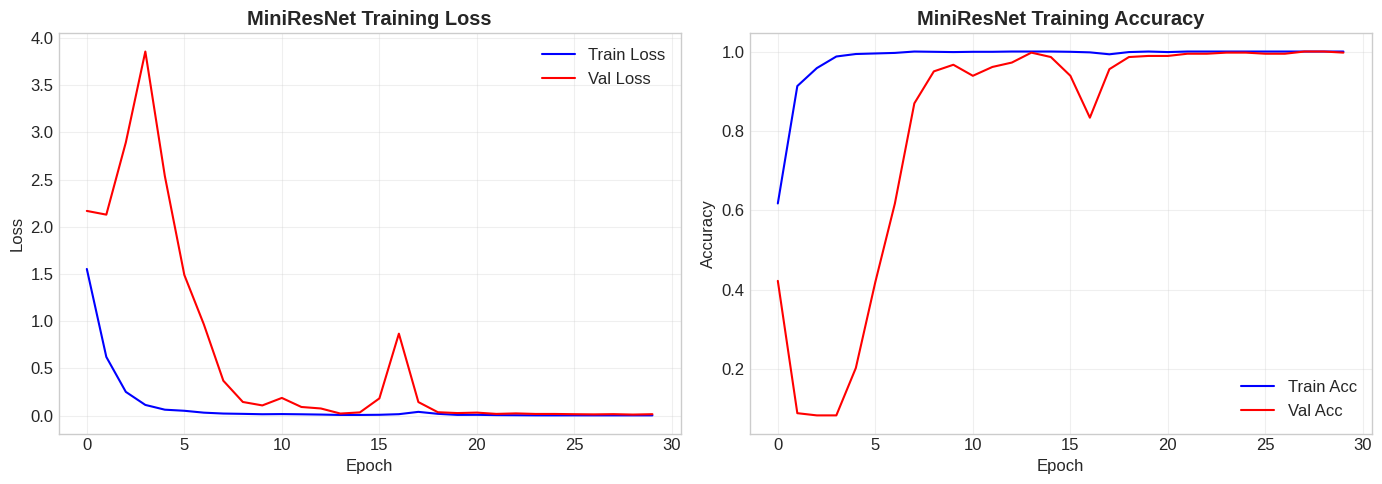

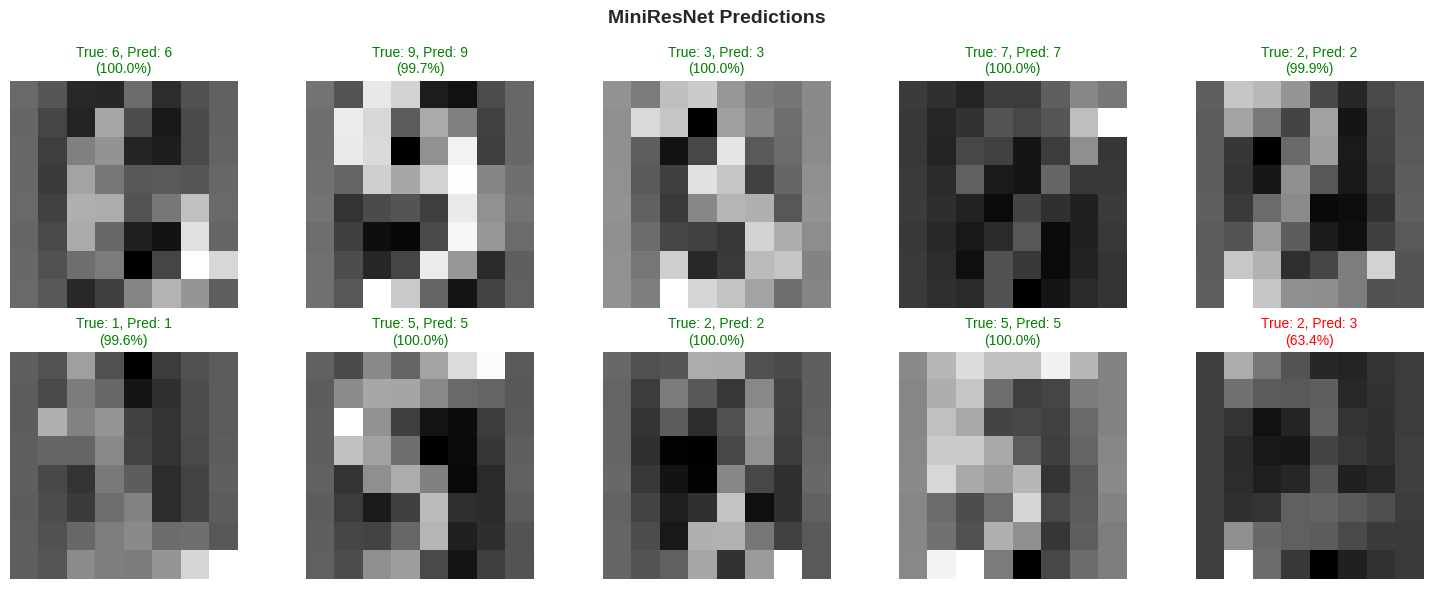

In [ ]:
# ============================================================================
#                    VISUALIZE TRAINING RESULTS
# ============================================================================

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['loss'], 'b-', label='Train Loss')
ax1.plot(history.history['val_loss'], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MiniResNet Training Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], 'b-', label='Train Acc')
ax2.plot(history.history['val_accuracy'], 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('MiniResNet Training Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('MiniResNet Predictions', fontsize=14, fontweight='bold')

predictions = resnet_model.predict(X_test[:10], verbose=0)
pred_classes = np.argmax(predictions, axis=1)

for i, ax in enumerate(axes.flatten()):
    img = X_test[i].reshape(8, 8)
    true_label = y_test[i]
    pred_label = pred_classes[i]
    confidence = predictions[i][pred_label] * 100

    ax.imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}\n({confidence:.1f}%)',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
#                         ADVANCED CHEAT SHEET
# ============================================================================

print("="*70)
print("              ADVANCED TENSORFLOW/KERAS CHEAT SHEET")
print("="*70)

cheat_sheet = """
GRADIENTTAPE PATTERNS
---------------------
# Basic gradient
with tf.GradientTape() as tape:
    y = model(x)
grads = tape.gradient(y, model.trainable_variables)

# Higher-order derivatives (nested tapes)
with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        y = f(x)
    dy = t1.gradient(y, x)
d2y = t2.gradient(dy, x)

# Jacobian
jacobian = tape.jacobian(y, x)

# Custom gradient
@tf.custom_gradient
def custom_op(x):
    def grad(dy):
        return dy * custom_backward
    return forward_result, grad

CUSTOM KERAS LAYERS
-------------------
class CustomLayer(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs, training=False):
        return inputs @ self.kernel

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config

CUSTOM TRAINING
---------------
# Override train_step for model.fit()
class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {'loss': loss}

GRADIENT MANIPULATION
---------------------
# Clip by global norm
grads, _ = tf.clip_by_global_norm(grads, max_norm=1.0)

# Gradient accumulation
accumulated = [acc + g/steps for acc, g in zip(accumulated, grads)]
"""
print(cheat_sheet)

              ADVANCED TENSORFLOW/KERAS CHEAT SHEET

GRADIENTTAPE PATTERNS
---------------------
# Basic gradient
with tf.GradientTape() as tape:
    y = model(x)
grads = tape.gradient(y, model.trainable_variables)

# Higher-order derivatives (nested tapes)
with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        y = f(x)
    dy = t1.gradient(y, x)
d2y = t2.gradient(dy, x)

# Jacobian
jacobian = tape.jacobian(y, x)

# Custom gradient
@tf.custom_gradient
def custom_op(x):
    def grad(dy):
        return dy * custom_backward
    return forward_result, grad

CUSTOM KERAS LAYERS
-------------------
class CustomLayer(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        super().build(input_shape)

---

# Conclusion

## Your Advanced TensorFlow & Keras Journey

Congratulations! You've mastered advanced TensorFlow and Keras techniques.

### What You Learned

| Part | Topic | Key Takeaway |
|------|-------|-------------|
| I | Advanced GradientTape | Nested tapes, Jacobians, custom gradients |
| II | Building Ops | Conv, pooling, normalization from scratch |
| III | Primitive Layers | Dense, Conv2D with only tf.Variable |
| IV | Custom Keras Layers | Proper subclassing with build() and call() |
| V | Advanced Architectures | ResNet, SE-Net, Transformer blocks |
| VI | Custom Training | Full control with GradientTape |
| VII | Practical Demos | Real-world model combining everything |

### When to Use What

| Approach | Use When |
|----------|----------|
| `model.fit()` | Standard training, quick prototyping |
| Custom `train_step()` | Custom logic but want callbacks/validation |
| Full GradientTape loop | GANs, RL, complex multi-model training |
| Custom layers | Reusable components, research |
| Primitive layers | Learning, debugging, maximum control |

### The Complete Learning Path

1. **NumPy from Scratch** - Understand the math deeply
2. **PyTorch** - Research-friendly framework
3. **TensorFlow/Keras Part 1** - Fundamentals and high-level API
4. **TensorFlow/Keras Part 2** - Advanced custom components (This notebook!)

### Next Steps

- **Vision Transformers (ViT)** - Transformers for images
- **Diffusion Models** - State-of-the-art generative AI
- **Neural Architecture Search** - Automated model design
- **Quantization & Pruning** - Model optimization for deployment
- **TensorFlow Extended (TFX)** - Production ML pipelines

---

*"The more you understand the primitives, the better you can innovate."*

**Happy Deep Learning!**